In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.13.1+cu116
Torchvision Version:  0.14.1+cu116


# Connect

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#Config

In [ ]:
class config:
  images_path = '/content/gdrive/MyDrive/licenta/dataset/poze'
  train_file_path = '/content/gdrive/MyDrive/licenta/dataset/train.txt'
  val_file_path = '/content/gdrive/MyDrive/licenta/dataset/validare.txt'
  test_file_path = '/content/gdrive/MyDrive/licenta/dataset/test.txt'
  save_path ='/content/gdrive/MyDrive/licenta/model_vgg16_scratch.pt'
  BATCH_SIZE = 16
  EPOCHS = 50
  LR = [0.001, 0.005]
  DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
data_dir = config.images_path
num_classes = 7
feature_extract = False

# Model definition

 Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift .

In [ ]:
class MyVGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(MyVGG16, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer6(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer12(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

# Train Function



In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=config.EPOCHS):
    since = time.time()

    val_history = {'val_acc':[], 'val_loss':[]}
    train_history = {'train_acc':[], 'train_loss':[]}
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(config.DEVICE)
                labels = labels.to(config.DEVICE)

                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), config.save_path)
            if phase == 'val':
                val_history['val_acc'].append(epoch_acc)
                val_history['val_loss'].append(epoch_loss)
            else:
                train_history['train_acc'].append(epoch_acc)
                train_history['train_loss'].append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_history, train_history

In [ ]:
def initialize_model( num_classes):
    model = MyVGG16(num_classes).to(config.DEVICE)
    input_size = 224
    return model, input_size

model, input_size = initialize_model( num_classes)

print(model)

MyVGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

Load Data
---------





In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),  # torchvision.transforms.ToTensor()  - It converts the PIL image with a pixel range of [0, 255] to a PyTorch FloatTensor of shape (C, H, W) with a range [0.0, 1.0].
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize([0.5601, 0.4995, 0.4742],[0.3366, 0.3381, 0.3437])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        transforms.Normalize([0.5601, 0.4995, 0.4742],[0.3366, 0.3381, 0.3437])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=config.BATCH_SIZE, shuffle=True, num_workers=4) for x in ['train', 'val']}


Initializing Datasets and Dataloaders...


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Create the Optimizer
--------------------




In [ ]:
model = model.to(config.DEVICE)
params_to_update = model.parameters()
# optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
optimizer = torch.optim.SGD(model.parameters(), lr=config.LR[1], weight_decay = 0.005, momentum = 0.9)

Run Training and Validation Step
--------------------------------






In [ ]:
criterion = nn.CrossEntropyLoss()
model,  val_history, train_history = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=config.EPOCHS)

Epoch 0/49
----------
train Loss: 1.6951 Acc: 0.3946
val Loss: 1.7142 Acc: 0.3210

Epoch 1/49
----------
train Loss: 1.6246 Acc: 0.4061
val Loss: 1.7196 Acc: 0.3199

Epoch 2/49
----------
train Loss: 1.6166 Acc: 0.4079
val Loss: 1.7117 Acc: 0.3204

Epoch 3/49
----------
train Loss: 1.6083 Acc: 0.4081
val Loss: 1.7055 Acc: 0.3204

Epoch 4/49
----------
train Loss: 1.6097 Acc: 0.4076
val Loss: 1.7634 Acc: 0.3210

Epoch 5/49
----------
train Loss: 1.6057 Acc: 0.4083
val Loss: 1.6884 Acc: 0.3322

Epoch 6/49
----------
train Loss: 1.6040 Acc: 0.4080
val Loss: 1.6973 Acc: 0.3210

Epoch 7/49
----------
train Loss: 1.6052 Acc: 0.4071
val Loss: 1.7179 Acc: 0.3234

Epoch 8/49
----------
train Loss: 1.6068 Acc: 0.4082
val Loss: 1.7378 Acc: 0.3368

Epoch 9/49
----------
train Loss: 1.6017 Acc: 0.4092
val Loss: 1.7182 Acc: 0.3204

Epoch 10/49
----------
train Loss: 1.5986 Acc: 0.4100
val Loss: 1.7065 Acc: 0.3275

Epoch 11/49
----------
train Loss: 1.6024 Acc: 0.4075
val Loss: 1.7169 Acc: 0.3204

Ep

Visualize the performance
------------------------------------------

In [ ]:
val_history, train_history

({'val_acc': [tensor(0.3210, device='cuda:0', dtype=torch.float64),
   tensor(0.3199, device='cuda:0', dtype=torch.float64),
   tensor(0.3204, device='cuda:0', dtype=torch.float64),
   tensor(0.3204, device='cuda:0', dtype=torch.float64),
   tensor(0.3210, device='cuda:0', dtype=torch.float64),
   tensor(0.3322, device='cuda:0', dtype=torch.float64),
   tensor(0.3210, device='cuda:0', dtype=torch.float64),
   tensor(0.3234, device='cuda:0', dtype=torch.float64),
   tensor(0.3368, device='cuda:0', dtype=torch.float64),
   tensor(0.3204, device='cuda:0', dtype=torch.float64),
   tensor(0.3275, device='cuda:0', dtype=torch.float64),
   tensor(0.3204, device='cuda:0', dtype=torch.float64),
   tensor(0.3234, device='cuda:0', dtype=torch.float64),
   tensor(0.3556, device='cuda:0', dtype=torch.float64),
   tensor(0.3204, device='cuda:0', dtype=torch.float64),
   tensor(0.3327, device='cuda:0', dtype=torch.float64),
   tensor(0.3204, device='cuda:0', dtype=torch.float64),
   tensor(0.3204, de

In [ ]:
def transform_history(instance):
  instance = instance.item()
  return instance

val_acc_history = list(map(transform_history, val_history['val_acc']))
train_acc_history = list(map(transform_history, train_history['train_acc']))

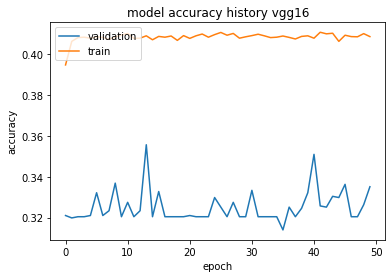

In [ ]:
# summarize history for accuracy
plt.plot(val_acc_history)
plt.plot(train_acc_history)
plt.title('model accuracy history vgg16')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['validation', 'train'], loc='upper left')
plt.show()

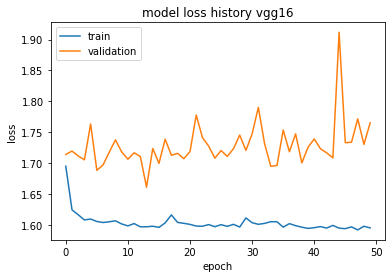

In [ ]:
# summarize history for loss
plt.plot(train_history['train_loss'])
plt.plot(val_history['val_loss'])
plt.title('model loss history vgg16')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Test model

In [ ]:
model

MyVGG16(
  (layer1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mod

In [ ]:
data_transforms_test = {
    'test': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

print("Initializing Datasets and Dataloaders...")

image_test_datasets = datasets.ImageFolder(root = os.path.join(data_dir,'test'),transform=data_transforms_test['test'])
dataloaders_test_dict = torch.utils.data.DataLoader(image_test_datasets, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=4)

Initializing Datasets and Dataloaders...


In [ ]:
dataloaders_test_dict.dataset

Dataset ImageFolder
    Number of datapoints: 3068
    Root location: /content/gdrive/MyDrive/licenta/dataset/poze/test
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear), antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [ ]:
len(dataloaders_test_dict)*config.BATCH_SIZE

3072

In [ ]:
def test_model(model, dataloader):
    since = time.time()
    model.eval()

    running_corrects = 0

    for inputs, labels in dataloader:
        inputs = inputs.to(config.DEVICE)
        labels = labels.to(config.DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)

            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloader.dataset)
    time_elapsed = time.time() - since
    print('Test complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Overall Acc: {:4f}'.format(acc))

    return acc

In [ ]:
test_acc = test_model(model,dataloaders_test_dict)

Test complete in 2m 57s
Overall Acc: 0.381030


In [ ]:
test_acc.item()

0.3810299869621903